## Bayesian Machine Learning Project 
### December 2023
### UVA School of Data Science MSDS 
#### Karolina Straznikiewicz 

# Credit Card Fraud Detection

#### 1. Load Packages

In [1]:
import pymc as pm
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import arviz as az
import seaborn as sns
import pandas as pd
import scipy.stats as stat
from scipy import special, stats 
import numpy as np 
az.style.use('arviz-darkgrid') 
color = '#87ceeb'
random_seed = 1993

In [2]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#### 2. Load Data

In [66]:
df = pd.read_csv("creditcard.csv")

In [7]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [8]:
df.shape

(284807, 31)

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

Time         V1         V2         V3         V4         V5  \
count 284807.000 284807.000 284807.000 284807.000 284807.000 284807.000   
mean   94813.860      0.000      0.000     -0.000      0.000      0.000   
std    47488.146      1.959      1.651      1.516      1.416      1.380   
min        0.000    -56.408    -72.716    -48.326     -5.683   -113.743   
25%    54201.500     -0.920     -0.599     -0.890     -0.849     -0.692   
50%    84692.000      0.018      0.065      0.180     -0.020     -0.054   
75%   139320.500      1.316      0.804      1.027      0.743      0.612   
max   172792.000      2.455     22.058      9.383     16.875     34.802   

              V6         V7         V8         V9  ...        V21        V22  \
count 284807.000 284807.000 284807.000 284807.000  ... 284807.000 284807.000   
mean       0.000     -0.000      0.000     -0.000  ...      0.000     -0.000   
std        1.332      1.237      1.194      1.099  ...      0.735      0.726   
min      -26.161    -43.557    -73.217    -13.434  ...    -34.830    -10.933   
25%       -0.768     -0.554     -0.209     -0.643  ...     -0.228     -0.542   
50%       -0.274      0.040      0.022     -0.051  ...     -0.029      0.007   
75%        0.399      0.570      0.327      0.597  ...      0.186      0.529   
max       73.302    120.589     20.007     15.595  ...     27.203     10.503   

             V23        V24        V25        V26        V27        V28  \
count 284807.000 284807.000 284807.000 284807.000 284807.000 284807.000   
mean       0.000      0.000      0.000      0.000     -0.000     -0.000   
std        0.624      0.606      0.521      0.482      0.404      0.330   
min      -44.808     -2.837    -10.295     -2.605    -22.566    -15.430   
25%       -0.162     -0.355     -0.317     -0.327     -0.071     -0.053   
50%       -0.011      0.041      0.017     -0.052      0.001      0.011   
75%        0.148      0.440      0.351      0.241      0.091      0.078   
max       22.528      4.585      7.520      3.517     31.612     33.848   

          Amount      Class  
count 284807.000 284807.000  
mean      88.350      0.002  
std      250.120      0.042  
min        0.000      0.000  
25%        5.600      0.000  
50%       22.000      0.000  
75%       77.165      0.000  
max    25691.160      1.000  

[8 rows x 31 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### 3. Exploratory Data Analysis 

#### Time

In [72]:
#Time in hours
df['Time_Hour'] = df['Time']/3600

Text(0, 0.5, 'Number of Transactions')

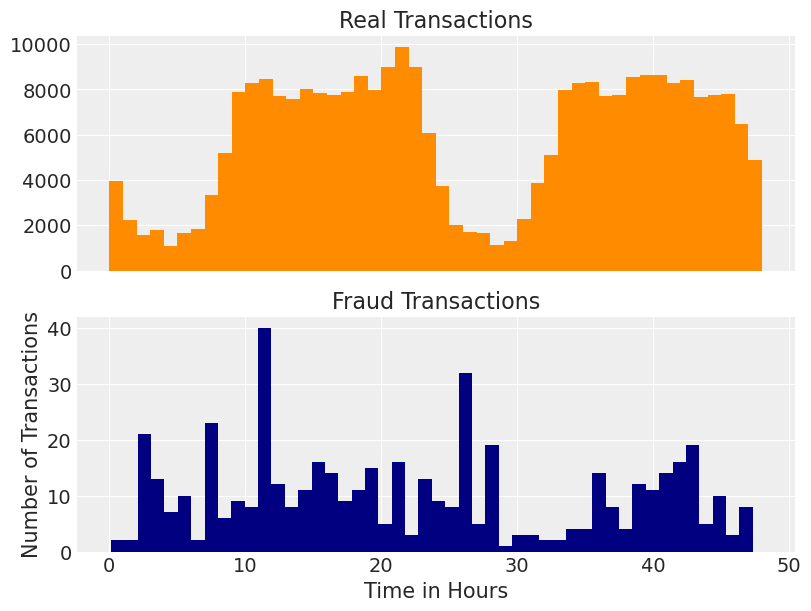

In [12]:
plt.rcParams.update({'font.size': 6})
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (8,6))
ax1.hist(df.Time_Hour[df.Class==0], bins=48, color = 'darkorange', alpha = 1)
ax1.set_title('Real Transactions')
ax2.hist(df.Time_Hour[df.Class==1], bins=48, color = 'navy', alpha = 1)
ax2.set_title('Fraud Transactions')
plt.xlabel('Time in Hours')
plt.ylabel('Number of Transactions')

The histograms indicate that there are no distinct patterns distinguishing real transactions from fraudulent ones. 'Time' variable does not seem to be a significant predictor in this context.

#### Amount

Text(0, 0.5, 'Number of Transactions')

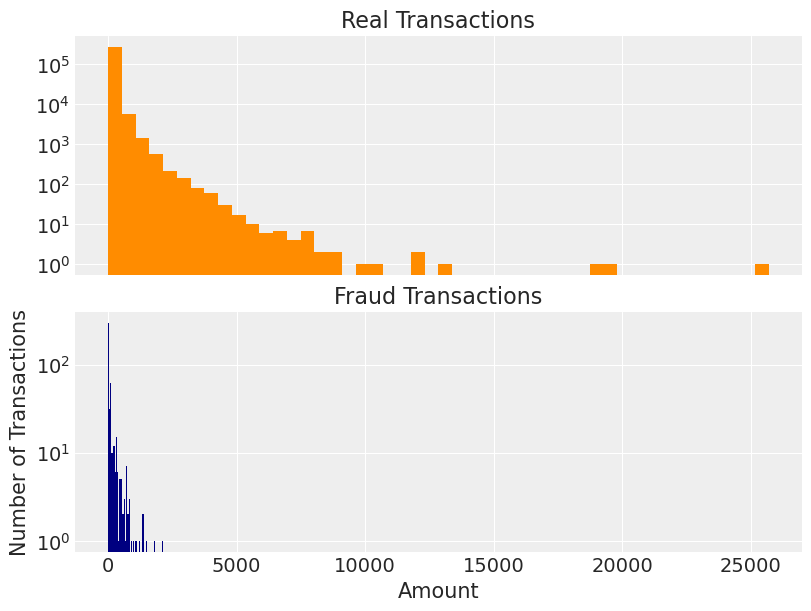

In [13]:
fig, (ax3, ax4) = plt.subplots(2,1, sharex = True, figsize = (8,6))
ax3.hist(df.Amount[df.Class==0], bins=48, color = 'darkorange', alpha = 1)
ax3.set_title('Real Transactions')
ax3.set_yscale('log')
ax4.hist(df.Amount[df.Class==1], bins=48, color = 'navy', alpha = 1)
ax4.set_title('Fraud Transactions')
ax4.set_yscale('log')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')

The 'Amount' variable shows a tendency for fraud transactions to cluster around lower values, whereas real transactions exhibit a wider range in amount values. This suggests that 'Amount' could be a significant predictor in distinguishing between fraudulent and genuine transactions.

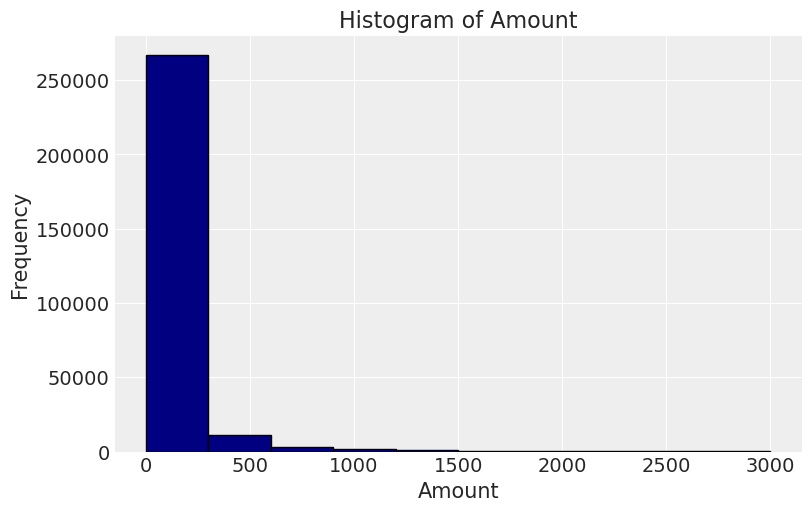

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(df['Amount'], bins=10, color='navy', edgecolor='black',range=(0, 3000))
plt.title('Histogram of Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### V-Variables

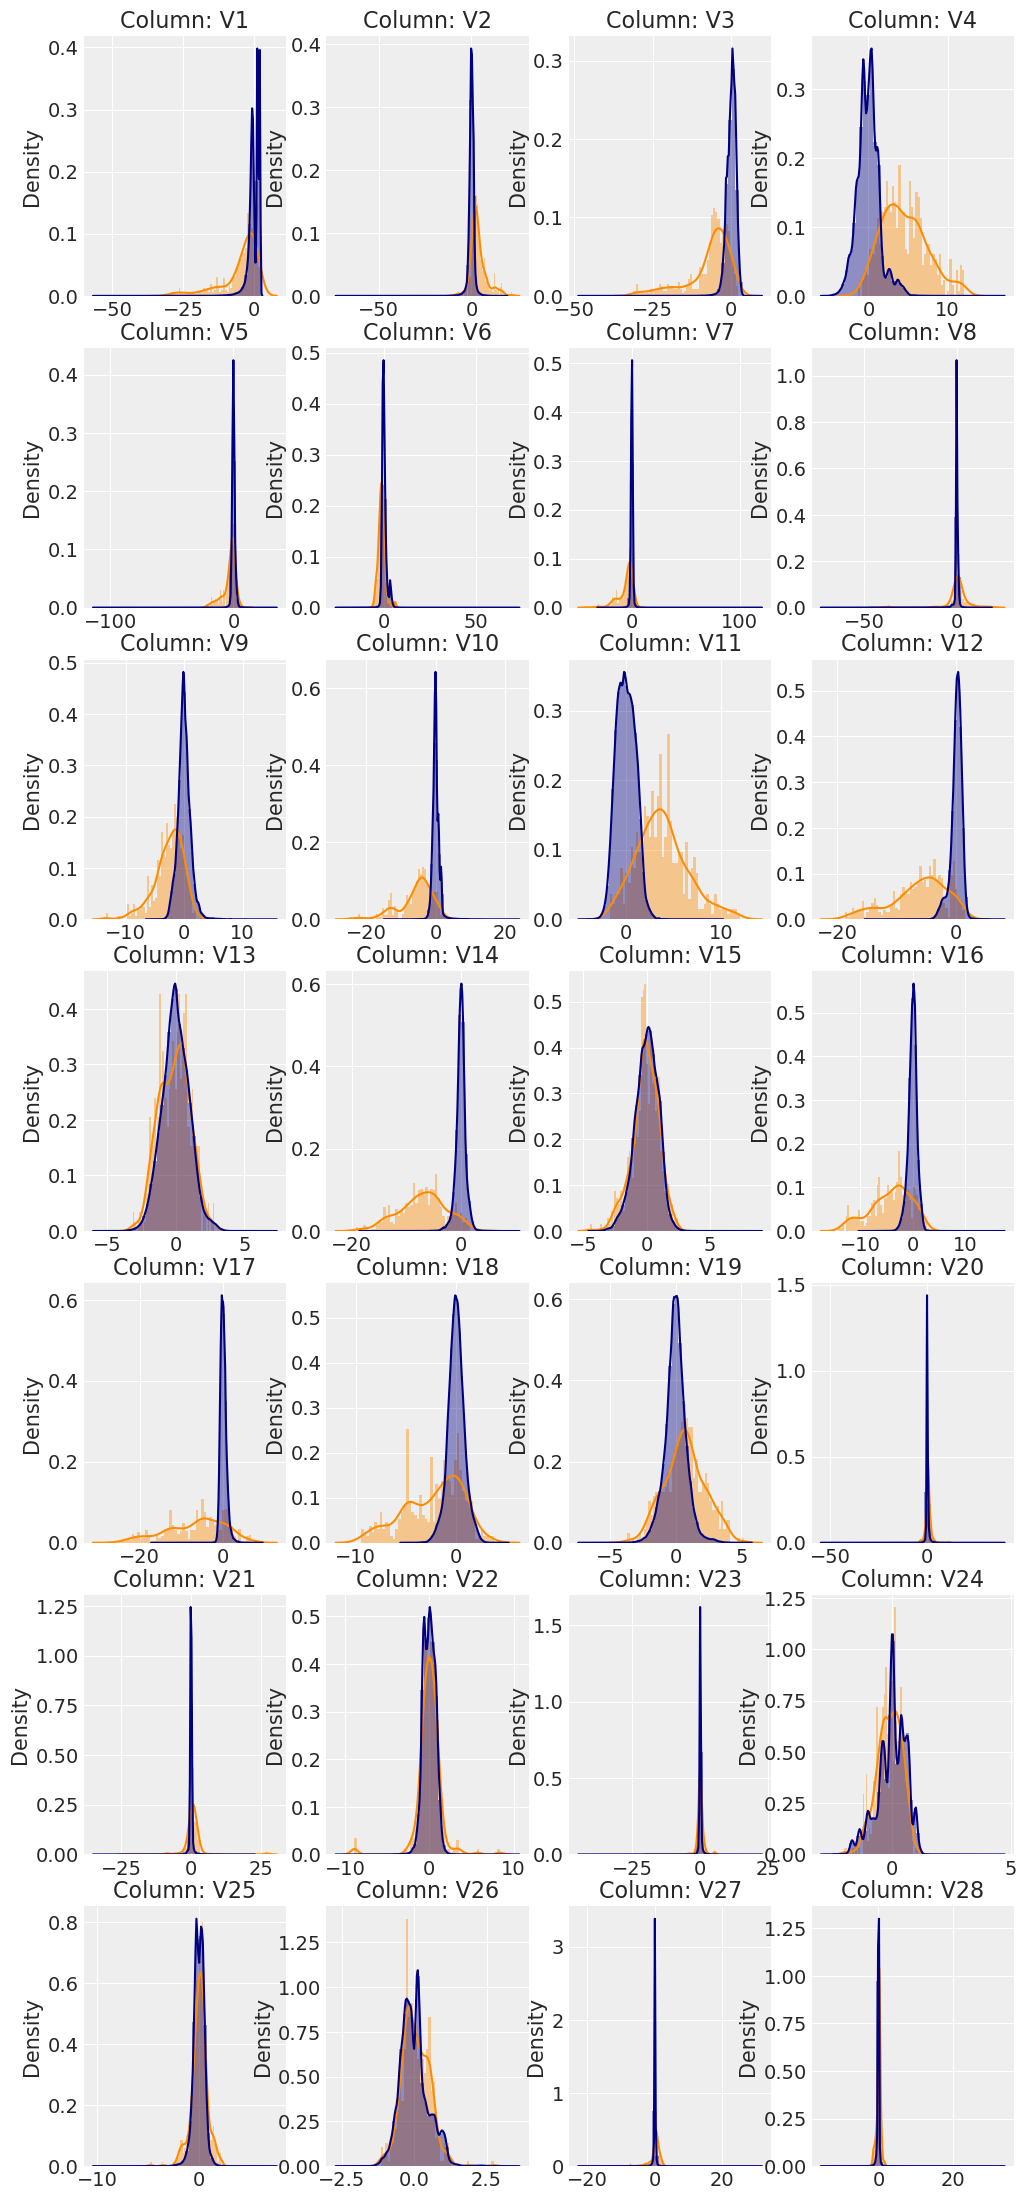

In [69]:
gs = gridspec.GridSpec(14,4)
plt.figure(figsize=(12,28*2))
for i,j in enumerate(df[df.iloc[:,1:29].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[j][df.Class==1], bins = 50, color = 'darkorange')
    sns.distplot(df[j][df.Class==0], bins = 50, color = 'navy')
    ax5.set_xlabel('')
    ax5.set_title('Column: ' + str(j))
plt.savefig('density.png')
plt.show()

Based on the density plots, the predictors V3, V4, V9, V10, V11, V12, V14, V16, V17, V18, and V19 will be included in the model, as their density distributions for real and fraud transactions show substantial differences, suggesting their potential significance in distinguishing between the two types of transactions.

#### Drop Unused Columns 

In [73]:
columns_to_drop = ['Time','Time_Hour','V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V13', 'V15', 'V20', 'V21', 'V22',
                  'V23','V24','V25','V26','V27','V28',]
df = df.drop(columns=columns_to_drop)

#### Normalize Amount

In [17]:
min_val = df['Amount'].min()
max_val = df['Amount'].max()
df['Amount'] = (df['Amount'] - min_val) / (max_val - min_val)

####  Correlations

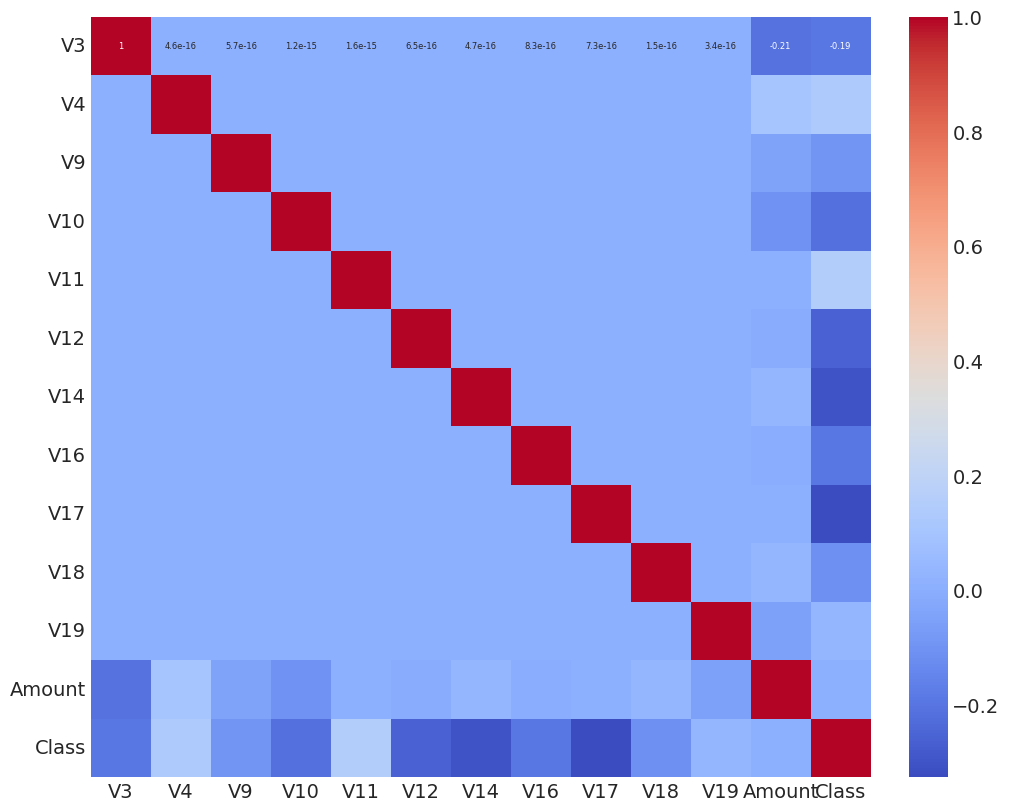

In [18]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

There are no significant correlations observed between the predictors, indicating that each variable provides unique information without redundancy.

#### Pair Plot

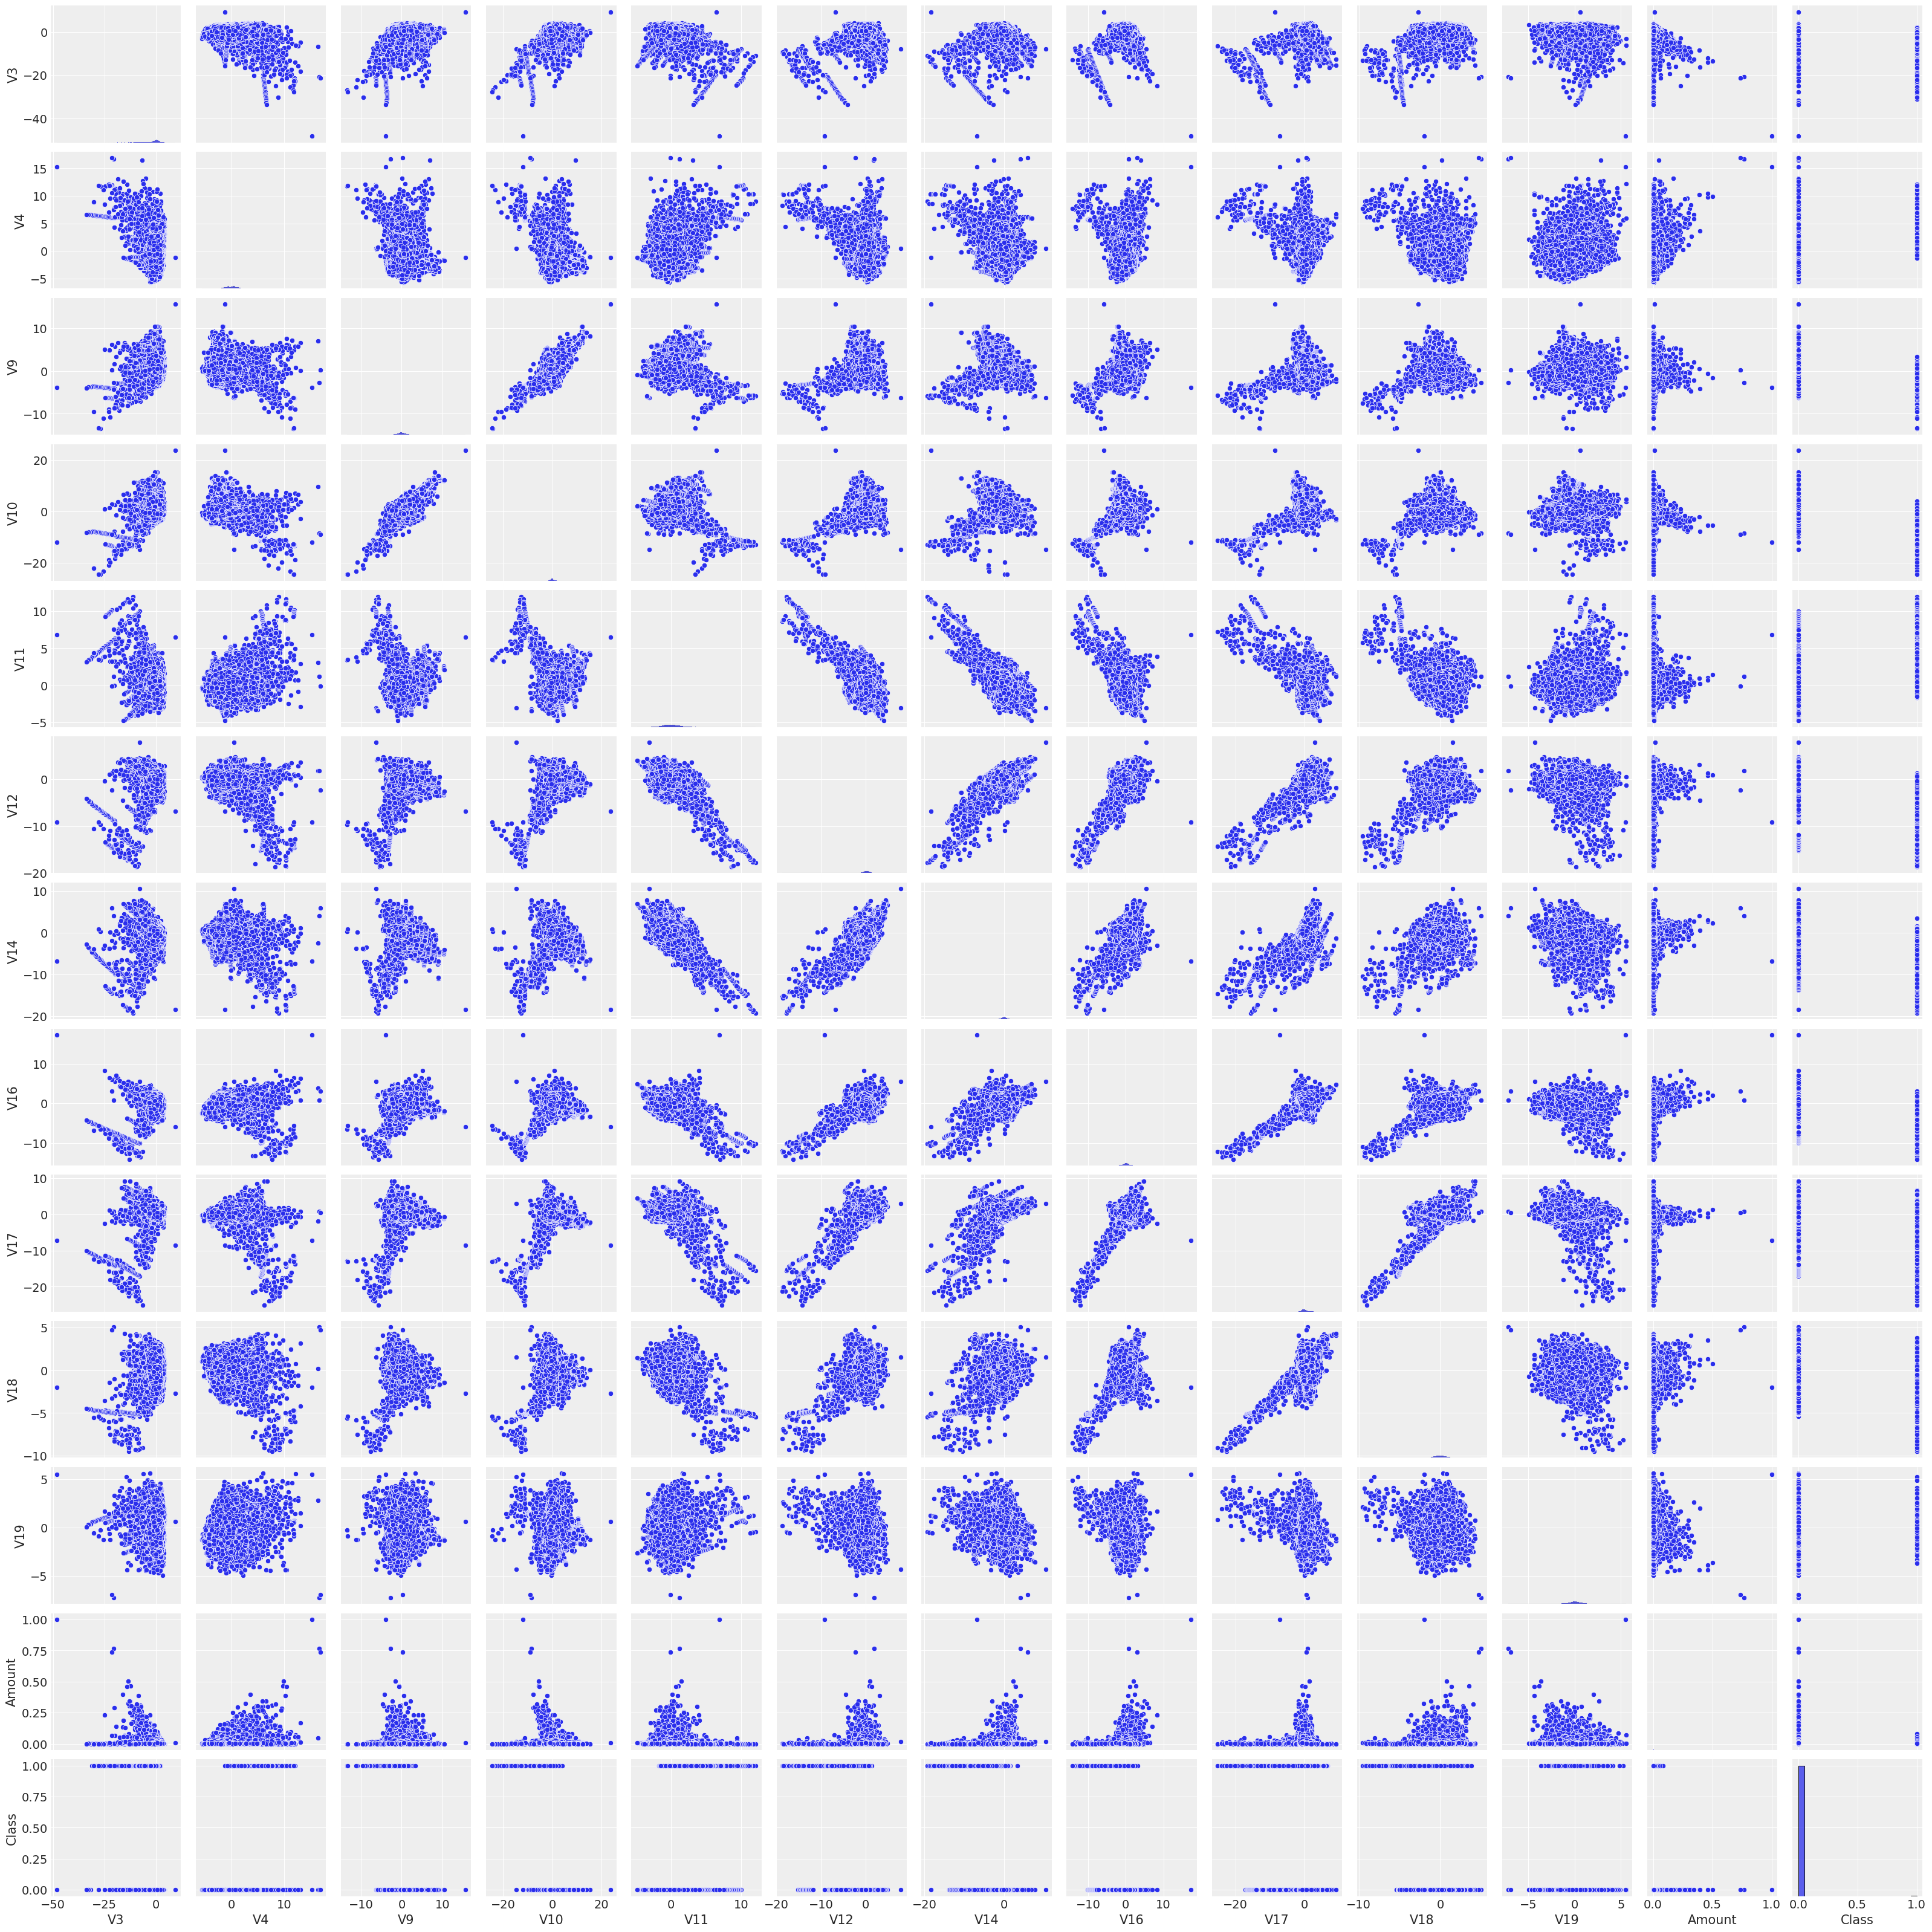

In [19]:
sns.pairplot(df)
plt.show()

Based on the pair plots, it appears that some predictors might have interactions with each other, suggesting the possibility of complex relationships influencing the model's predictive power.

#### Histograms of predictors

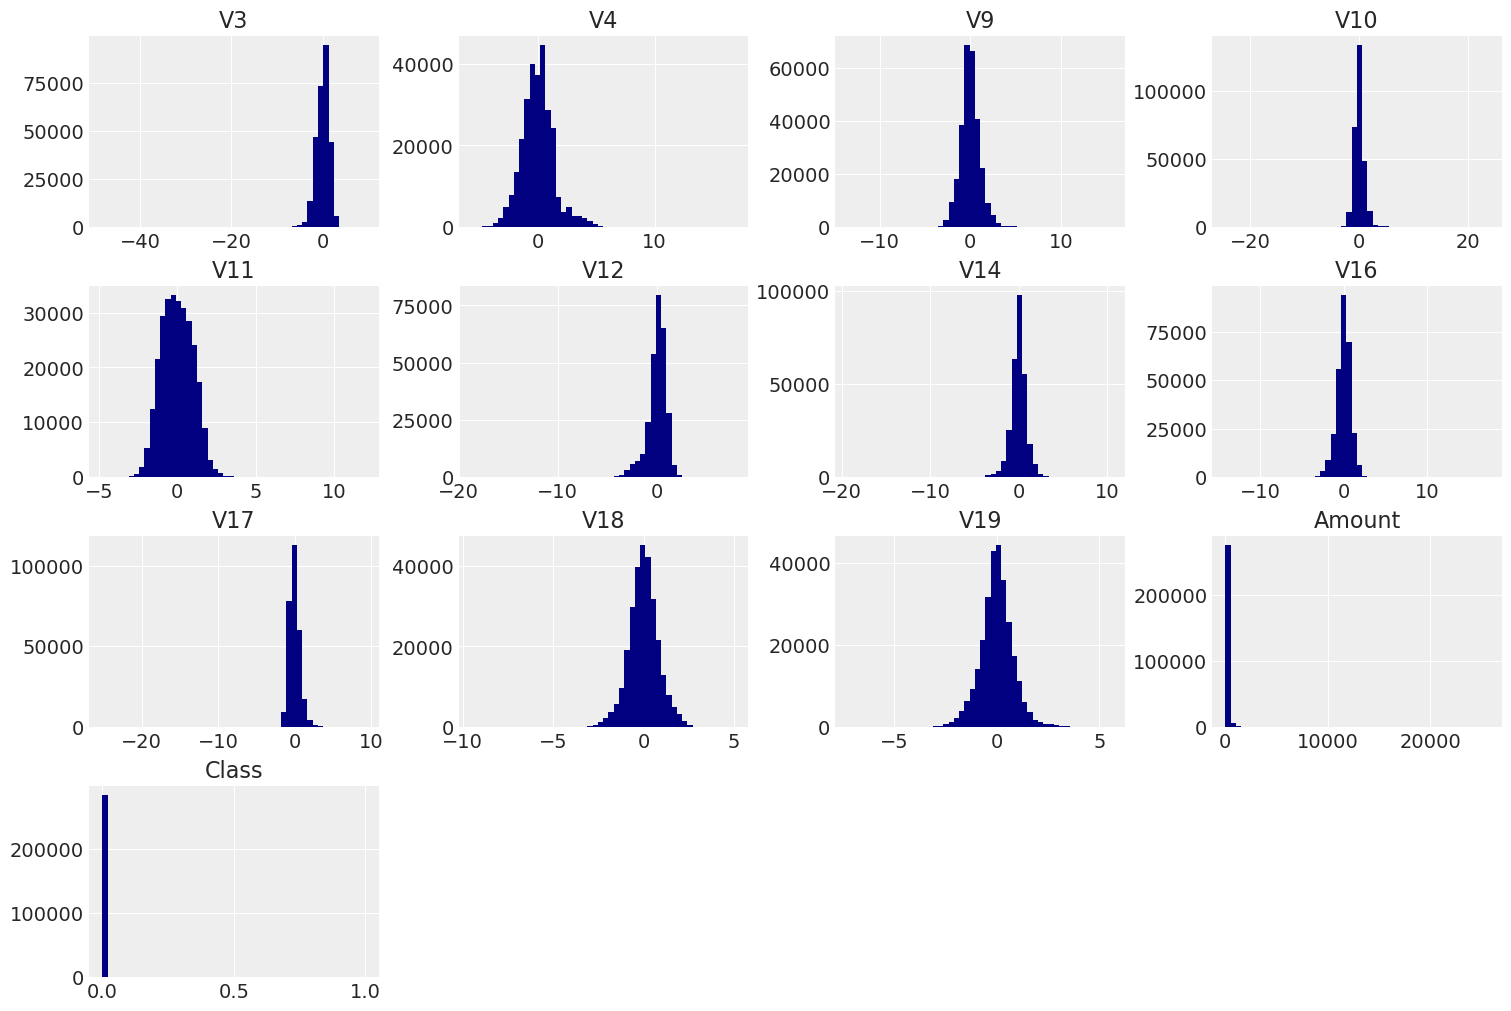

In [74]:
df.hist(bins=50, figsize=(15,10),color = 'navy')
plt.show()

#### 3. Split data into Train and Test Set

In [21]:
y = df['Class'].values
X = df.drop(['Class'],axis = 1).values 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 13, stratify = y)

#### 4. Prediction with Naive Bayes 

In [22]:
def get_predictions(clf, X_train, y_train, X_test):
    clf=clf
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    train_pred = clf.predict(X_train)
    print('train-set confussion matrix:\n', confusion_matrix(y_train,train_pred))
    print()
    return y_pred, y_prob

In [23]:
def print_scores(y_test, y_pred, y_prob): 
    print('test-set confussion matrix:\n', confusion_matrix(y_test, y_pred))
    print()
    print('recall score: ', recall_score(y_test,y_pred))
    print()
    print('precission score: ', precision_score(y_test,y_pred))
    print()
    print('f1 score: ', f1_score(y_test, y_pred))
    print()
    print('accuracy score: ',accuracy_score(y_test,y_pred))
    print()
    print('ROC AUC: {}'.format(roc_auc_score(y_test, y_prob[:,1])))

#### Gaussian Naive Bayes 

In [24]:
y_pred, y_prob = get_predictions(GaussianNB(), X_train, y_train,X_test)
print_scores(y_test, y_pred, y_prob)

train-set confussion matrix:
 [[225660   1791]
 [    53    341]]

test-set confussion matrix:
 [[56413   451]
 [   22    76]]

recall score:  0.7755102040816326

precission score:  0.1442125237191651

f1 score:  0.2432

accuracy score:  0.9916962185316527

ROC AUC: 0.9597053262779507


The provided metrics reflect the performance of a classification model on a highly imbalanced dataset, which is a common challenge in fields like fraud detection. The confusion matrices for both the training and test sets show that the model is quite effective in identifying the majority class (non-fraud transactions), as evidenced by the high number of true negatives (225660 in training, 56413 in testing). However, the number of false negatives (53 in training, 22 in testing) indicates that while the model successfully captures most of the fraudulent transactions, it still misses some.

The recall score of approximately 0.776 is quite high, suggesting that the model is capable of identifying a substantial proportion of the actual positive (fraudulent) cases. This is crucial in imbalanced datasets, as the cost of missing positive cases (frauds) is typically much higher than incorrectly identifying negative cases (legitimate transactions) as positive.

However, the precision score of around 0.144 is low, indicating that a significant number of transactions predicted as frauds are actually legitimate. This could lead to unnecessary investigations or blocking of legitimate transactions, which might be costly or inconvenient.

The F1 score, which balances precision and recall, is about 0.2432, reflecting the trade-off between these two metrics in a scenario where detecting positive cases is critical but comes with the cost of a higher false positive rate.

The accuracy score of approximately 0.992 is very high, but in the context of highly imbalanced data, this metric can be misleading. High accuracy might simply reflect the model's ability to recognize the majority class, which is not the primary concern in tasks like fraud detection.

Finally, the ROC AUC of about 0.960 is impressive, indicating that the model has a strong ability to differentiate between the two classes across various thresholds. This suggests that the model is generally effective, but there might be room for improvement, particularly in reducing false positives without significantly sacrificing the ability to detect true positives.


Incorporating a Bayesian logistic regression model in fraud detection with highly imbalanced data could better address the inherent uncertainties, thanks to its probabilistic nature and the ability to incorporate prior knowledge. Bayesian models offer probabilistic outputs, which are particularly advantageous in imbalanced datasets, providing a nuanced measure of the model's confidence in its predictions. They also quantify uncertainty in parameter estimates, allowing for a deeper understanding of the influence of each feature. The flexibility in setting decision thresholds based on the probabilistic outputs can lead to more effective minimization of misclassification costs, crucial in fraud detection. Additionally, Bayesian models' robustness to overfitting and facility for model comparison and refinement make them particularly suitable for tackling the challenges presented by imbalanced datasets, potentially leading to a more accurate balance between detecting frauds and reducing false positives.

#### 5. Bayesian Logistic Regression 

#### Model

In developing the model, I opted for Normal distributions as priors for most of the β parameters (β0, β2 to β12) based on the histograms of these variables, which appeared normally distributed. Since I lacked specific information about these predictors, I chose a mean (mu) of 0, indicating a neutral effect, and a standard deviation (sigma) of 2, reflecting moderate uncertainty. For β1, associated with the scaled 'Amount', I selected a Beta distribution with parameters alpha=0.5 and beta=10, as this variable's values are concentrated near 0 and decline quickly, making the Beta distribution a suitable choice. I experimented with different distributions, including Student's t-distribution and uniform distribution, and varied the values for mu and sigma. However, I found that the current choices converged best with this data, indicating that these priors appropriately captured the underlying patterns and uncertainties of my dataset without introducing strong biases, especially given the limited domain-specific knowledge about some of the predictors.

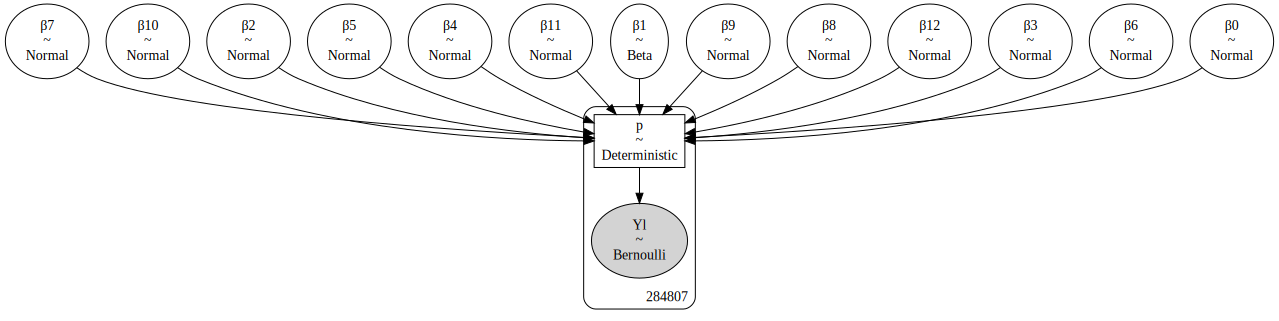

In [25]:
with pm.Model() as glm_model:

    Y = df["Class"]

    β0 = pm.Normal('β0', mu=0, sigma=2)
    β1 = pm.Beta('β1', alpha=0.5, beta=10)
    β2 = pm.Normal('β2', mu=0, sigma=2)
    β3 = pm.Normal('β3', mu=0, sigma=2)
    β4 = pm.Normal('β4', mu=0, sigma=2)
    β5 = pm.Normal('β5', mu=0, sigma=2)
    β6 = pm.Normal('β6', mu=0, sigma=2)
    β7 = pm.Normal('β7', mu=0, sigma=2)
    β8 = pm.Normal('β8', mu=0, sigma=2)
    β9 = pm.Normal('β9', mu=0, sigma=2)
    β10 = pm.Normal('β10', mu=0, sigma=2)
    β11 = pm.Normal('β11', mu=0, sigma=2)
    β12 = pm.Normal('β12', mu=0, sigma=2)

    η = (β0 + β1 * df["Amount"] + β2 * df['V3'] + β3 * df["V4"] + β4 * df["V9"] 
         + β5 * df["V10"] + β6 * df["V11"] + β7 * df["V12"] + β8 * df["V14"]
         + β9 * df["V16"] + β10 * df["V17"] + β11 * df["V18"] + β12 * df["V19"])

    # Link function
    p = pm.Deterministic('p', pm.math.invlogit(η))

    # Likelihood
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)


model_graph = pm.model_to_graphviz(glm_model)
model_graph

#### Sample to get posterior

In [26]:
with glm_model:
    trace = pm.sample(1000, tune=100, random_seed = random_seed, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, β2, β3, β4, β5, β6, β7, β8, β9, β10, β11, β12]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 1628 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### 6. Evaluation 

#### Prior Evaluation 

array([[<Axes: title={'center': 'β0'}>, <Axes: title={'center': 'β0'}>],
       [<Axes: title={'center': 'β1'}>, <Axes: title={'center': 'β1'}>],
       [<Axes: title={'center': 'β2'}>, <Axes: title={'center': 'β2'}>],
       [<Axes: title={'center': 'β3'}>, <Axes: title={'center': 'β3'}>],
       [<Axes: title={'center': 'β4'}>, <Axes: title={'center': 'β4'}>],
       [<Axes: title={'center': 'β5'}>, <Axes: title={'center': 'β5'}>],
       [<Axes: title={'center': 'β6'}>, <Axes: title={'center': 'β6'}>],
       [<Axes: title={'center': 'β7'}>, <Axes: title={'center': 'β7'}>],
       [<Axes: title={'center': 'β8'}>, <Axes: title={'center': 'β8'}>],
       [<Axes: title={'center': 'β9'}>, <Axes: title={'center': 'β9'}>],
       [<Axes: title={'center': 'β10'}>, <Axes: title={'center': 'β10'}>],
       [<Axes: title={'center': 'β11'}>, <Axes: title={'center': 'β11'}>],
       [<Axes: title={'center': 'β12'}>, <Axes: title={'center': 'β12'}>]],
      dtype=object)

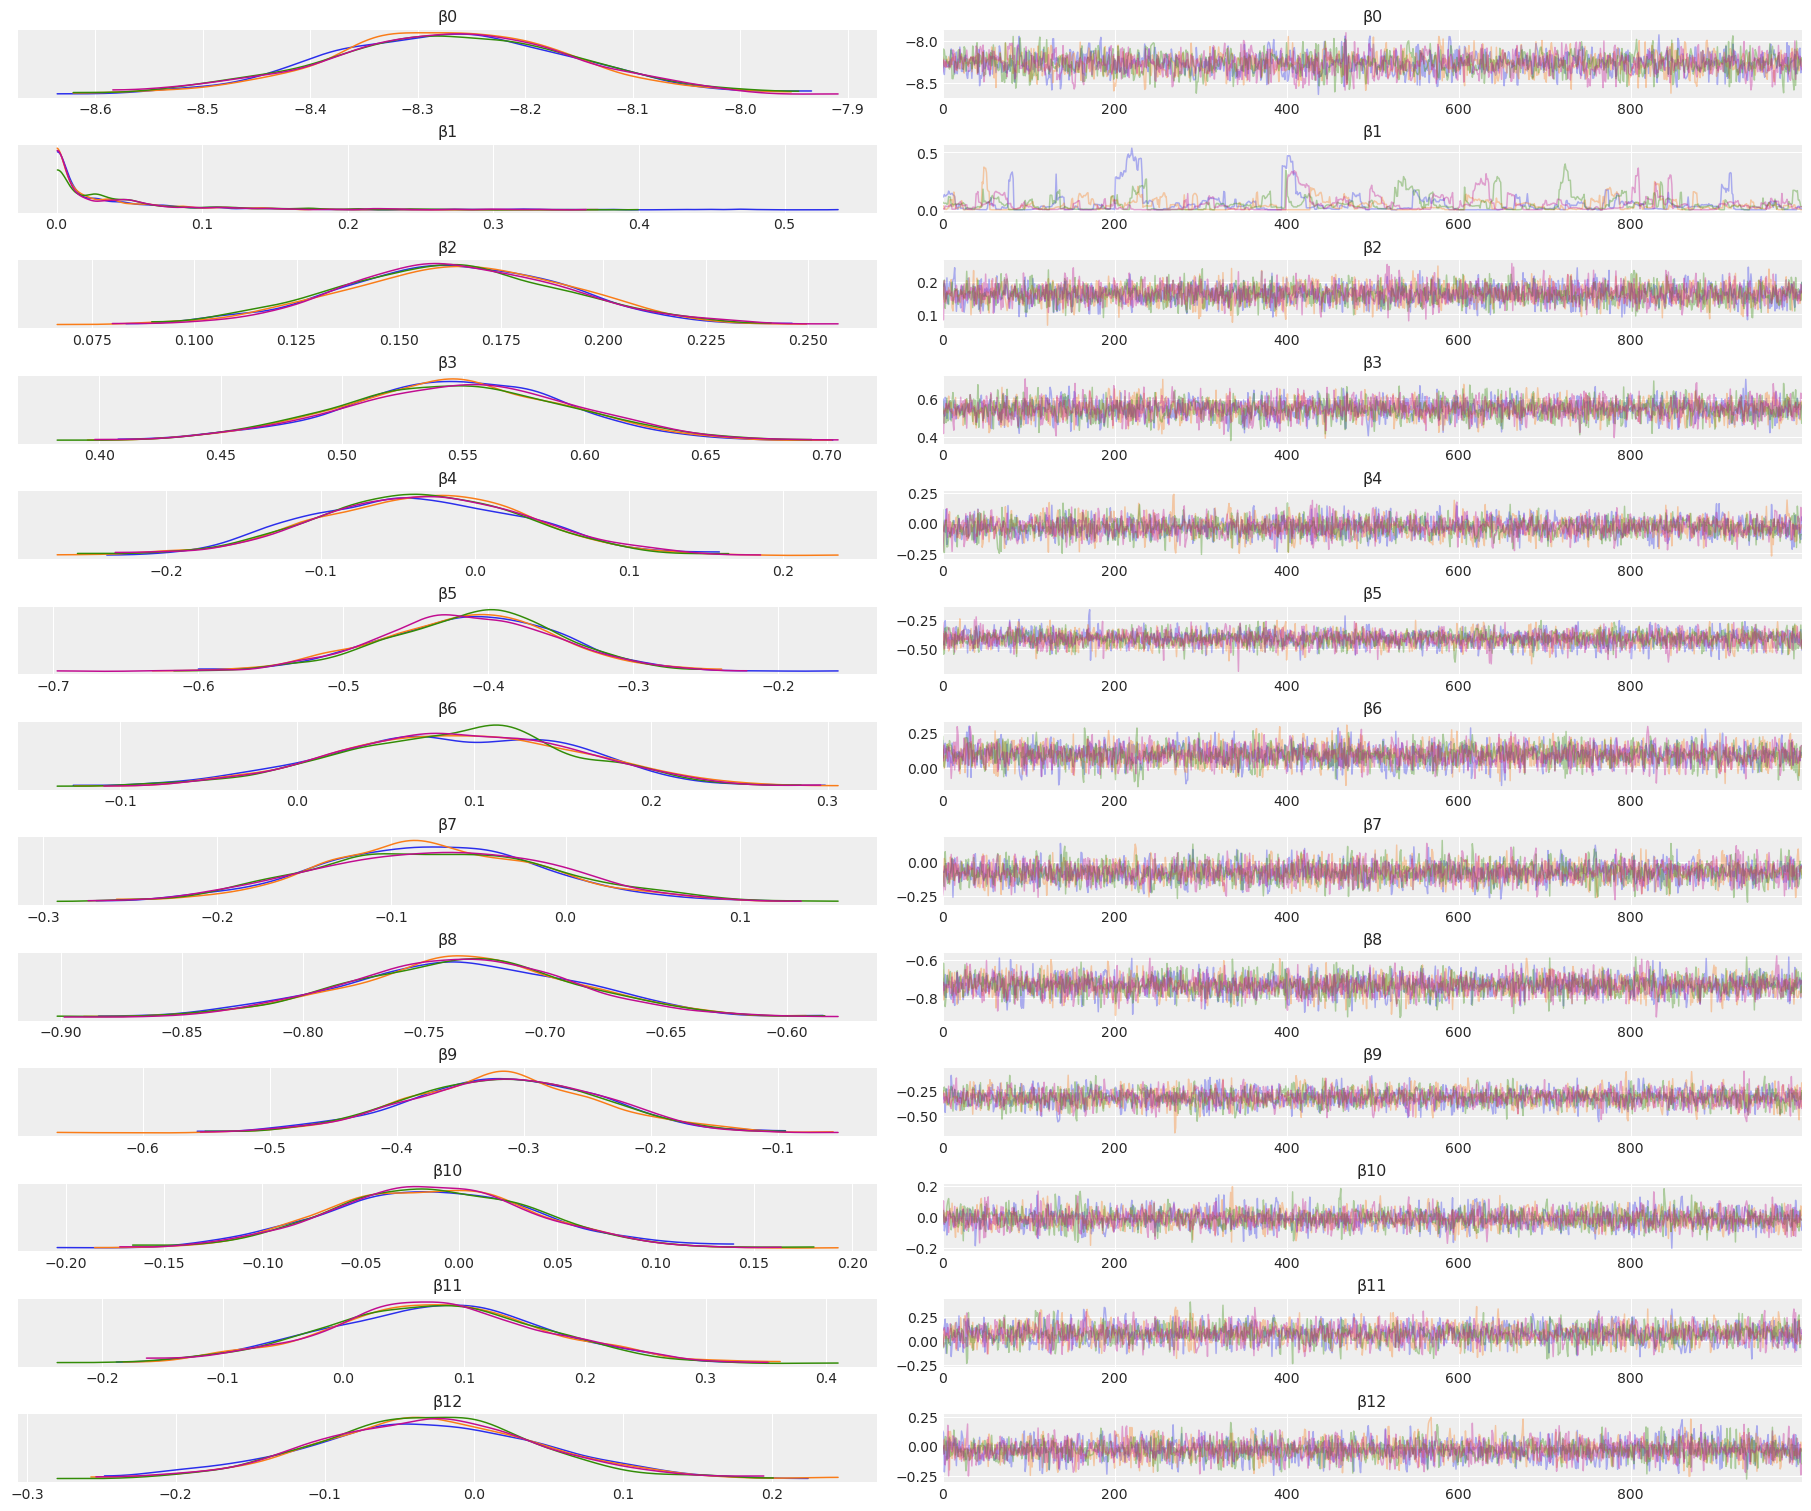

In [40]:
az.plot_trace(trace, compact = False, var_names = ['β0','β1','β2','β3','β4','β5','β6','β7','β8','β9','β10','β11','β12'],
              figsize = (18,15))

Good convergence for all V predictors. Amount predictor might need some improvement. 

#### Sampling Performance 

In [41]:
az.summary(trace, var_names= ['β0','β1','β2','β3','β4','β5','β6','β7','β8','β9','β10','β11','β12'])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β0  -8.270 0.114  -8.487   -8.055      0.002    0.002  2877.000  2584.000   
β1   0.048 0.069   0.000    0.163      0.004    0.003   218.000   207.000   
β2   0.164 0.028   0.115    0.219      0.000    0.000  4675.000  3528.000   
β3   0.547 0.046   0.461    0.636      0.001    0.001  4091.000  3399.000   
β4  -0.035 0.070  -0.161    0.097      0.001    0.001  4435.000  3101.000   
β5  -0.413 0.061  -0.529   -0.300      0.001    0.001  4269.000  3302.000   
β6   0.091 0.068  -0.036    0.216      0.001    0.001  4834.000  3015.000   
β7  -0.076 0.067  -0.205    0.048      0.001    0.001  4537.000  2949.000   
β8  -0.735 0.048  -0.821   -0.641      0.001    0.001  4556.000  3608.000   
β9  -0.315 0.077  -0.457   -0.170      0.001    0.001  3952.000  3061.000   
β10 -0.014 0.053  -0.109    0.087      0.001    0.001  4209.000  2860.000   
β11  0.075 0.091  -0.101    0.245      0.002    0.001  3461.000  2858.000   
β12 -0.031 0.076  -0.179    0.111      0.001    0.001  4447.000  2798.000   

     r_hat  
β0   1.000  
β1   1.020  
β2   1.000  
β3   1.000  
β4   1.000  
β5   1.000  
β6   1.000  
β7   1.000  
β8   1.000  
β9   1.000  
β10  1.000  
β11  1.000  
β12  1.000

R hats are all 1 showing good convergence. Amount has a low number of samples; may cause some issues. 

#### Posterior Predictive Checks

In [42]:
pp = pm.sample_posterior_predictive(trace, model = glm_model,random_seed = random_seed)

Sampling: [Yl]


<Axes: title={'center': 'Yl / Yl'}>

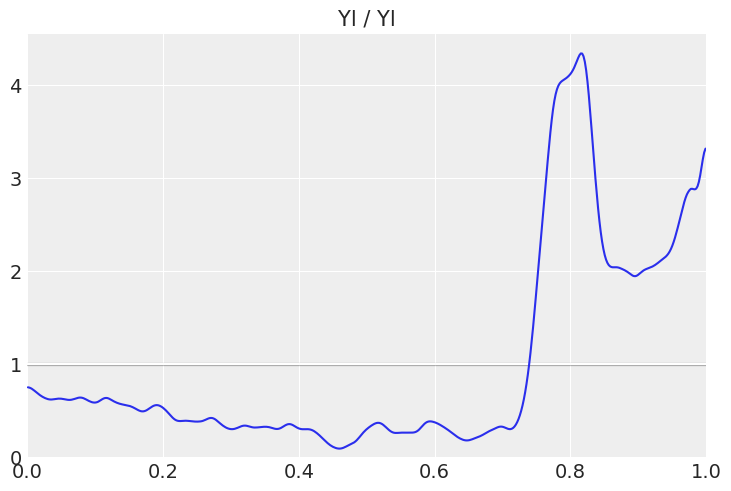

In [32]:
az.plot_bpv(pp)

The Bayesian p-value plot compares the observed data with data simulated from the model's posterior predictive distribution. It helps in assessing whether the model is consistent with the observed data. A Bayesian p-value close to 0.5 suggests a good model fit, whereas values close to 0 or 1 indicate a potential lack of fit.

Bayesian p-value predominantly centers around 0.5. However, a significant spike well above 1 on the x-axis is observed, indicating the presence of a potential discrepancy between the model's predictions and the observed data in that specific region.

#### Other Performance Metrics

In [43]:
from scipy.special import expit as logistic

In [80]:
coef_means = np.array([trace.posterior['β1'].mean().values, 
                       trace.posterior['β2'].mean().values,
                       trace.posterior['β3'].mean().values, 
                       trace.posterior['β4'].mean().values,
                       trace.posterior['β5'].mean().values, 
                       trace.posterior['β6'].mean().values,
                       trace.posterior['β7'].mean().values, 
                       trace.posterior['β8'].mean().values,
                       trace.posterior['β9'].mean().values, 
                       trace.posterior['β10'].mean().values,
                       trace.posterior['β11'].mean().values,
                       trace.posterior['β12'].mean().values])


η_test = logistic(np.dot(X_test, coef_means) + trace.posterior['β0'].mean().values)

#### 0.5

In [81]:
y_pred = η_test > 0.5
precision, recall, thresholds = precision_recall_curve(y_test, η_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# ROC-AUC
roc_auc = roc_auc_score(y_test, η_test)

# F1 Score
f1 = f1_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

In [82]:
print("Accuracy:", accuracy)
print()
print("ROC AUC:", roc_auc)
print()
print("F1 Score:", f1)
print()
print("Confusion Matrix:\n", cm)
print()

Accuracy: 0.9984902215512096

ROC AUC: 0.7795667859152665

F1 Score: 0.2181818181818182

Confusion Matrix:
 [[56864     0]
 [   86    12]]



The high accuracy of approximately 0.998 indicates that the model is successful in correctly classifying the majority of transactions. However, in the context of highly imbalanced datasets, such as fraud detection where fraudulent transactions are rare, accuracy can be misleading. The ROC AUC of around 0.780, which measures the model's ability to distinguish between fraudulent and non-fraudulent transactions, is moderate. This suggests that the model has a reasonable capability in differentiating between the two classes, but there's room for improvement. The F1 Score, a harmonic mean of precision and recall, is relatively low at approximately 0.218, indicating a potential imbalance between the model's precision and recall. This is further evidenced by the confusion matrix, which shows that while the model correctly identified all non-fraudulent transactions (56864 true negatives), it missed a significant number of fraudulent transactions (86 false negatives) and only correctly identified 12 fraud cases (true positives). This outcome highlights a challenge in fraud detection models: while they can be highly accurate in identifying the majority class (legitimate transactions), their ability to detect the minority class (fraudulent transactions) is often limited. 

#### Precision-Recall curve

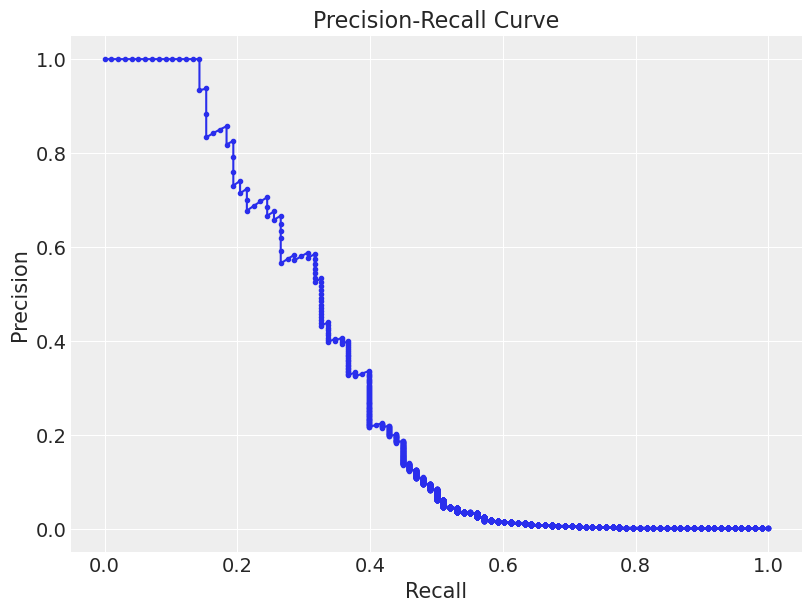

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Precision (y-axis) is the ratio of true positive predictions to the total number of positive predictions made (i.e., the proportion of predicted positives that are actually positive). It measures the accuracy of the positive predictions.

Recall (x-axis), also known as sensitivity or true positive rate, is the ratio of true positive predictions to the total number of actual positives. It measures the model's ability to detect positive instances

In the context of credit card fraud detection, the observed behavior of the Precision-Recall Curve, where the precision starts to decline around a recall of 0.2 and drops to 0 at a recall of 0.6, reveals key insights into the model's performance. Initially, the model exhibits high precision at low recall levels, meaning it accurately identifies a substantial proportion of fraudulent transactions without flagging many false positives. However, as the model's recall increases beyond 0.2, aiming to capture more fraudulent transactions, its precision decreases. This indicates a growing number of legitimate transactions being incorrectly classified as fraud. The significant drop in precision at a recall of 0.6 is especially crucial; beyond this point, the model predominantly makes false positive predictions, rendering it ineffective for practical use. 

Analysis with different threshold values did not significantly improve the model's performance.

#### 7. Results

#### Posterior Plots

array([[<Axes: title={'center': 'β0'}>, <Axes: title={'center': 'β1'}>,
        <Axes: title={'center': 'β2'}>, <Axes: title={'center': 'β3'}>],
       [<Axes: title={'center': 'β4'}>, <Axes: title={'center': 'β5'}>,
        <Axes: title={'center': 'β6'}>, <Axes: title={'center': 'β7'}>],
       [<Axes: title={'center': 'β8'}>, <Axes: title={'center': 'β9'}>,
        <Axes: title={'center': 'β10'}>, <Axes: title={'center': 'β11'}>],
       [<Axes: title={'center': 'β12'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

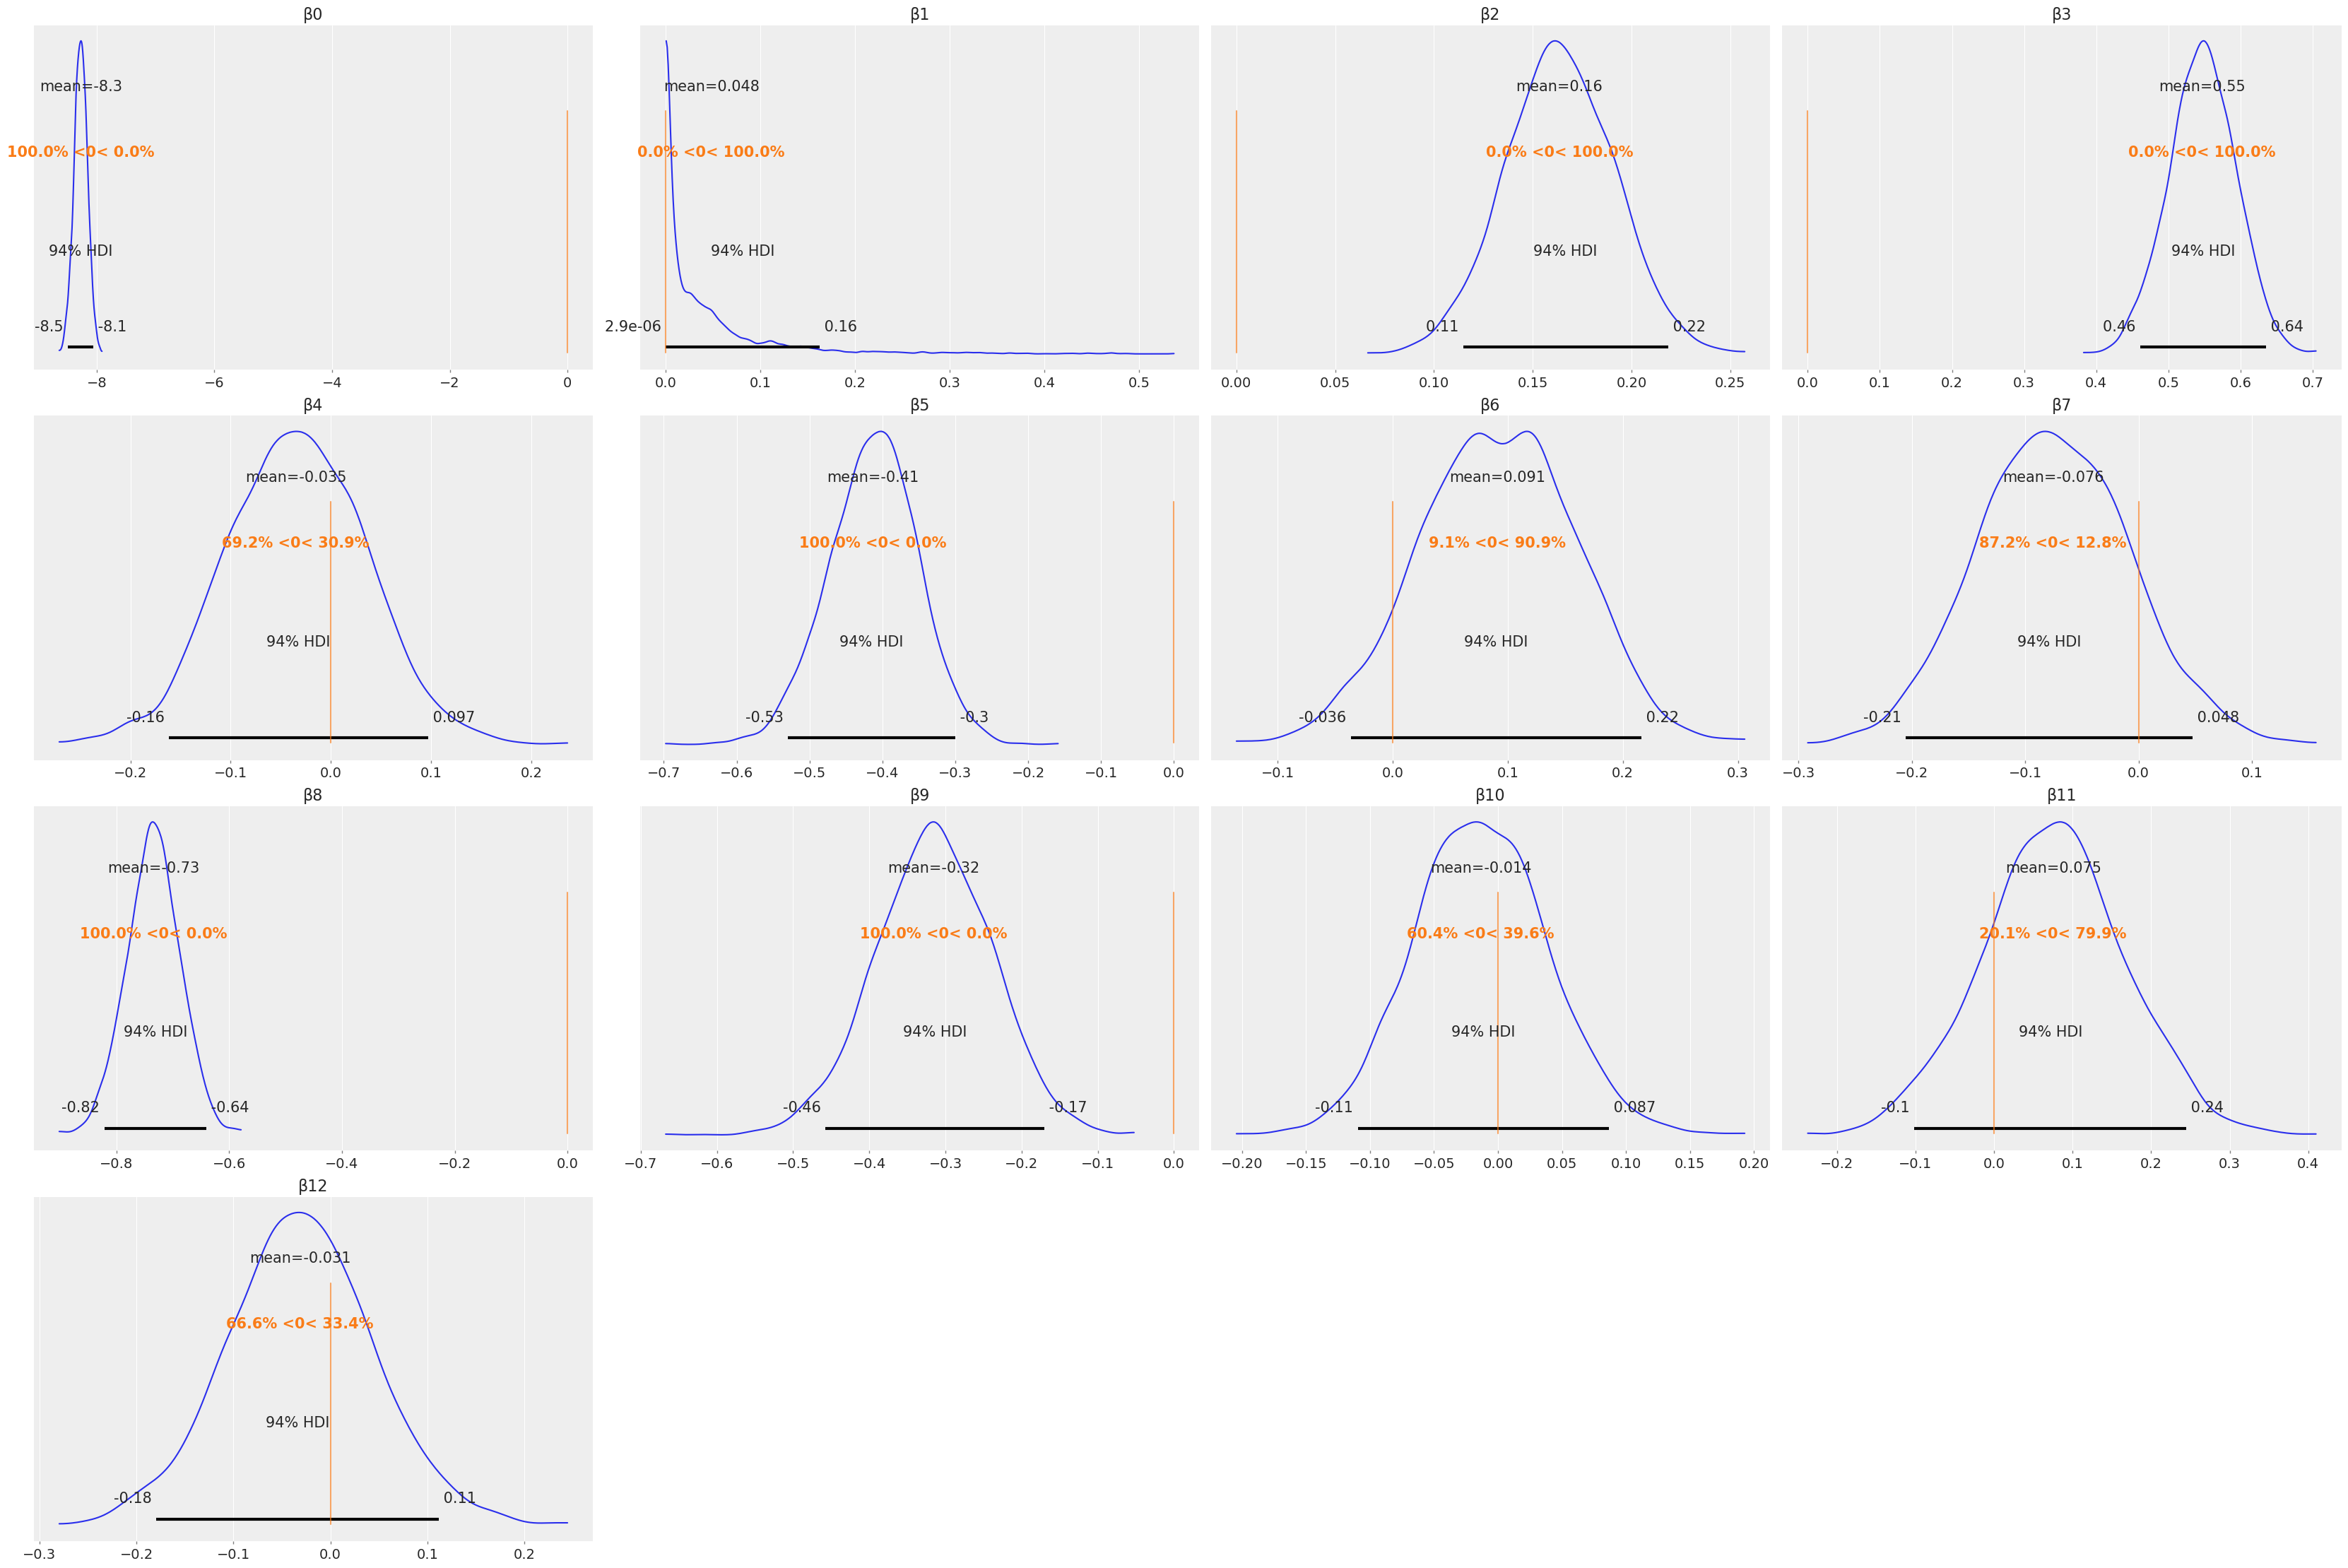

In [88]:
az.plot_posterior(trace,
                  var_names=['β0','β1','β2','β3','β4','β5','β6','β7','β8','β9','β10','β11','β12'], ref_val = 0)

The posterior plots highlight six significant predictors: 'Amount,' 'V3,' 'V4,' 'V10,' 'V14,' and 'V16.'

#### Prediction Credible Intervals 

In [49]:
with glm_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['p'])

Sampling: []


In [50]:
posterior_predictive_samples=ppc.posterior_predictive['p']

In [51]:
flattened_samples = posterior_predictive_samples.values.reshape(-1, posterior_predictive_samples.shape[2])
lower_bound = np.percentile(flattened_samples, 2.5, axis=0)
upper_bound = np.percentile(flattened_samples, 97.5, axis=0)

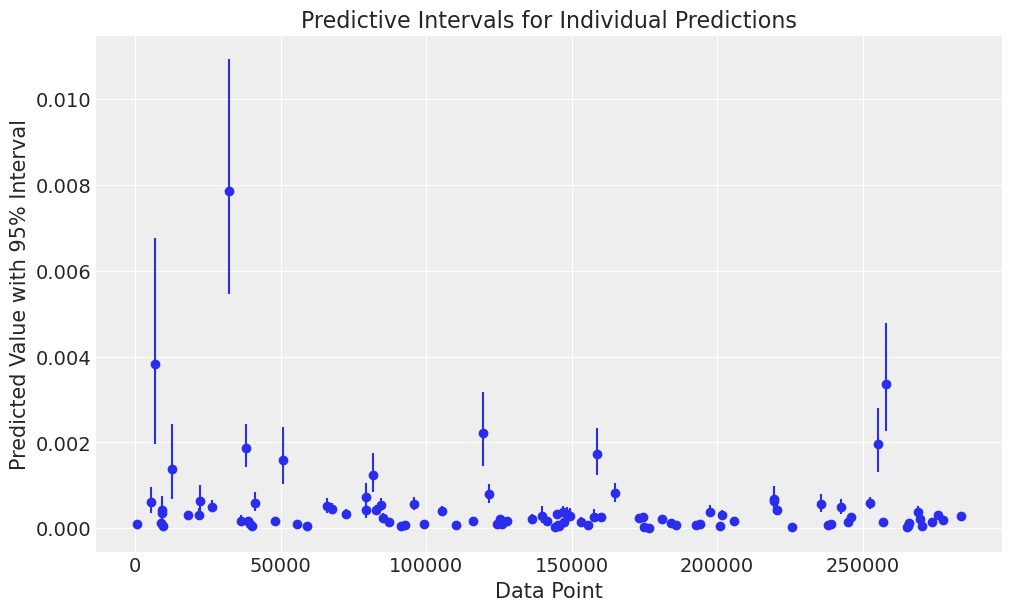

In [52]:
num_points_to_plot = min(100, flattened_samples.shape[1])

indices = np.random.choice(flattened_samples.shape[1], num_points_to_plot, replace=False)

plt.figure(figsize=(10, 6))
plt.errorbar(x=indices, 
             y=np.mean(flattened_samples[:, indices], axis=0),
             yerr=[np.mean(flattened_samples[:, indices], axis=0) - lower_bound[indices],
                   upper_bound[indices] - np.mean(flattened_samples[:, indices], axis=0)],
             fmt='o')
plt.title("Predictive Intervals for Individual Predictions")
plt.xlabel("Data Point")
plt.ylabel("Predicted Value with 95% Interval")
plt.show()

Many predictions feature very narrow credible intervals, while others are wider. Narrow intervals carry more certainty in classifying transactions.